<a href="https://colab.research.google.com/github/kumi125/phishing_url_detector.ipynb/blob/main/phishing_url_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install -q tldextract


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 4.4 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
from urllib.parse import urlparse
import tldextract

# small in-notebook dataset (safe, mostly example.com variants)
data = [
    # legit (label 0)
    ("https://www.google.com", 0),
    ("https://github.com", 0),
    ("https://www.bankofamerica.com", 0),
    ("https://in.linkedin.com", 0),
    ("https://stackoverflow.com/questions", 0),
    ("https://example.com/about", 0),

    # phishing-like (label 1) -- synthethic / demonstrative examples
    ("http://secure-login.example.com/paypal/verify", 1),
    ("http://paypal.verify-login.example.com", 1),
    ("http://192.168.100.10/account/login", 1),           # IP in URL
    ("http://example.com@malicious.com/login", 1),        # @ trick
    ("http://login-paypal.example.com/login", 1),
    ("http://verify-apple.example.com/security", 1)
]

df = pd.DataFrame(data, columns=["url", "label"])
df.head(12)


,url,label
0,https://www.google.com,0
1,https://github.com,0
2,https://www.bankofamerica.com,0
3,https://in.linkedin.com,0
4,https://stackoverflow.com/questions,0
5,https://example.com/about,0
6,http://secure-login.example.com/paypal/verify,1
7,http://paypal.verify-login.example.com,1
8,http://192.168.100.10/account/login,1
9,http://example.com@malicious.com/login,1


In [ ]:
def simple_rule_phish(url):
    u = url.lower()
    score = 0

    # common suspicious signs
    if '@' in u:
        score += 3
    if re.search(r'(\d{1,3}\.){3}\d{1,3}', u):  # IP address in URL
        score += 3
    if len(u) > 75:
        score += 1
    if u.count('-') > 2:
        score += 1
    if not u.startswith('https://'):
        score += 1
    # suspicious keywords that often appear in phishing URLs
    for kw in ['login', 'verify', 'secure', 'account', 'update', 'confirm']:
        if kw in u:
            score += 1

    # domain vs subdomain trick: long subdomain + brand keyword is suspicious
    ext = tldextract.extract(u)
    subdomain = ext.subdomain or ""
    domain = ext.domain or ""
    if len(subdomain) > 20 and any(b in subdomain for b in ['paypal','bank','apple','login']):
        score += 2

    # threshold (tuneable)
    return 1 if score >= 4 else 0

# apply to our sample df
df['pred_rule'] = df['url'].apply(simple_rule_phish)
df[['url','label','pred_rule']]


,url,label,pred_rule
0,https://www.google.com,0,0
1,https://github.com,0,0
2,https://www.bankofamerica.com,0,0
3,https://in.linkedin.com,0,0
4,https://stackoverflow.com/questions,0,0
5,https://example.com/about,0,0
6,http://secure-login.example.com/paypal/verify,1,1
7,http://paypal.verify-login.example.com,1,0
8,http://192.168.100.10/account/login,1,1
9,http://example.com@malicious.com/login,1,1


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion matrix:")
print(confusion_matrix(df['label'], df['pred_rule']))
print("\nClassification report:")
print(classification_report(df['label'], df['pred_rule'], digits=3))


Confusion matrix:
[[6 0]
 [3 3]]

Classification report:
              precision    recall  f1-score   support

           0      0.667     1.000     0.800         6
           1      1.000     0.500     0.667         6

    accuracy                          0.750        12
   macro avg      0.833     0.750     0.733        12
weighted avg      0.833     0.750     0.733        12



In [ ]:
import pandas as pd

data = [
    # Legit URLs
    ("https://www.google.com", 0),
    ("https://github.com", 0),
    ("https://www.microsoft.com", 0),
    ("https://en.wikipedia.org/wiki/Main_Page", 0),
    ("https://www.amazon.com", 0),
    ("https://stackoverflow.com/questions", 0),
    ("https://www.bbc.com/news", 0),
    ("https://www.bankofamerica.com", 0),

    # Phishing-like URLs (examples for training)
    ("http://192.168.0.1/paypal/verify", 1),
    ("http://secure-login.paypal.com.verify-update.co", 1),
    ("http://appleid.apple.com.security-login.ru", 1),
    ("http://verify-bankofamerica.login-secure.xyz", 1),
    ("http://paypal.com.user.verify.account.update.com", 1),
    ("http://secure-amazon.verify-payment.info", 1),
    ("http://google.com.login.verify-user.co", 1),
    ("http://microsoft.com.account.update-service.info", 1),
]

df = pd.DataFrame(data, columns=["url", "label"])
df


,url,label
0,https://www.google.com,0
1,https://github.com,0
2,https://www.microsoft.com,0
3,https://en.wikipedia.org/wiki/Main_Page,0
4,https://www.amazon.com,0
5,https://stackoverflow.com/questions,0
6,https://www.bbc.com/news,0
7,https://www.bankofamerica.com,0
8,http://192.168.0.1/paypal/verify,1
9,http://secure-login.paypal.com.verify-update.co,1


In [ ]:
print("Shape:", df.shape)
print(df['label'].value_counts())
df.head()


Shape: (16, 2)
label
0    8
1    8
Name: count, dtype: int64


,url,label
0,https://www.google.com,0
1,https://github.com,0
2,https://www.microsoft.com,0
3,https://en.wikipedia.org/wiki/Main_Page,0
4,https://www.amazon.com,0


In [ ]:
# 1 — Feature extraction function
import re

def extract_features(df):
    df['url_length'] = df['url'].apply(len)
    df['num_dots'] = df['url'].apply(lambda x: x.count('.'))
    df['num_hyphens'] = df['url'].apply(lambda x: x.count('-'))
    df['has_https'] = df['url'].apply(lambda x: 1 if x.lower().startswith('https') else 0)
    df['has_ip_address'] = df['url'].apply(lambda x: 1 if re.search(r'(\d{1,3}\.){3}\d{1,3}', x) else 0)
    df['suspicious_keywords'] = df['url'].apply(lambda x: 1 if any(k in x.lower() for k in ['login', 'verify', 'update', 'secure']) else 0)
    return df


In [ ]:
df_features = extract_features(df.copy())
df_features.head()


,url,label,url_length,num_dots,num_hyphens,has_https,has_ip_address,suspicious_keywords
0,https://www.google.com,0,22,2,0,1,0,0
1,https://github.com,0,18,1,0,1,0,0
2,https://www.microsoft.com,0,25,2,0,1,0,0
3,https://en.wikipedia.org/wiki/Main_Page,0,39,2,0,1,0,0
4,https://www.amazon.com,0,22,2,0,1,0,0


In [ ]:
X = df_features.drop(columns=['url', 'label'])
y = df_features['label']

print("Feature matrix shape:", X.shape)
X.head()


Feature matrix shape: (16, 6)


,url_length,num_dots,num_hyphens,has_https,has_ip_address,suspicious_keywords
0,22,2,0,1,0,0
1,18,1,0,1,0,0
2,25,2,0,1,0,0
3,39,2,0,1,0,0
4,22,2,0,1,0,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=4, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 1.0


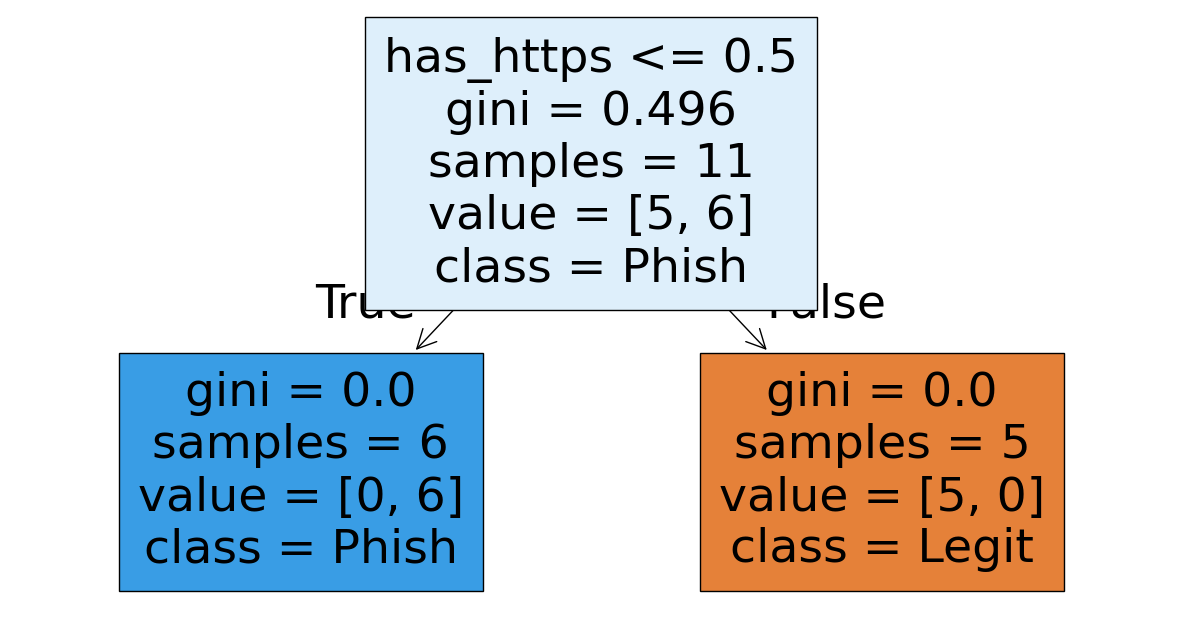

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
tree.plot_tree(model, feature_names=X.columns, class_names=["Legit", "Phish"], filled=True)
plt.show()


In [ ]:
def predict_url(urls):
    # Make a DataFrame from the URLs
    temp_df = pd.DataFrame({'url': urls})

    # Dummy labels (not used for prediction)
    temp_df['label'] = 0

    # Extract features
    temp_features = extract_features(temp_df)
    X_new = temp_features.drop(columns=['url', 'label'])

    # Predict
    predictions = model.predict(X_new)

    # Map to text labels
    result = ["Phish" if p == 1 else "Legit" for p in predictions]

    return list(zip(urls, result))


In [ ]:
test_urls = [
    "https://secure-login-paypal.com/verify",
    "https://www.google.com",
    "http://192.168.0.1/login",
    "https://apple.com",
    "https://account-update-secure.com"
]

for url, status in predict_url(test_urls):
    print(f"{url} --> {status}")


https://secure-login-paypal.com/verify --> Legit
https://www.google.com --> Legit
http://192.168.0.1/login --> Phish
https://apple.com --> Legit
https://account-update-secure.com --> Legit


In [ ]:
!pip install gradio


In [ ]:
import gradio as gr

def predict_single_url(url):
    temp_df = pd.DataFrame({'url': [url], 'label': [0]})
    temp_features = extract_features(temp_df)
    X_new = temp_features.drop(columns=['url', 'label'])
    pred = model.predict(X_new)[0]
    return "Phish 🚨" if pred == 1 else "Legit ✅"

with gr.Blocks() as demo:
    gr.Markdown("# 🛡️ Phishing URL Detector")
    url_input = gr.Textbox(label="Enter a URL to check", placeholder="https://example.com")
    output_label = gr.Label()
    check_button = gr.Button("Check URL")

    check_button.click(fn=predict_single_url, inputs=url_input, outputs=output_label)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3bcef7b44c27878b2e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install ucimlrepo


In [ ]:
from ucimlrepo import fetch_ucirepo
dataset = fetch_ucirepo(id=967)  # PhiUSIIL dataset ID
X_all = dataset.data.features
y_all = dataset.data.targets

print("Features matrix shape:", X_all.shape)
print("Label distribution:\n", y_all.value_counts())


Features matrix shape: (235795, 54)
Label distribution:
 label
1        134850
0        100945
Name: count, dtype: int64


In [ ]:
# Look at the first few rows
import pandas as pd

df = pd.DataFrame(X_all)
df['label'] = y_all.values
print(df.head())

# Check class balance
print("\nLabel counts:")
print(df['label'].value_counts())


                                  URL  URLLength                      Domain  \
0    https://www.southbankmosaics.com         31    www.southbankmosaics.com   
1            https://www.uni-mainz.de         23            www.uni-mainz.de   
2      https://www.voicefmradio.co.uk         29      www.voicefmradio.co.uk   
3         https://www.sfnmjournal.com         26         www.sfnmjournal.com   
4  https://www.rewildingargentina.org         33  www.rewildingargentina.org   

   DomainLength  IsDomainIP  TLD  URLSimilarityIndex  CharContinuationRate  \
0            24           0  com               100.0              1.000000   
1            16           0   de               100.0              0.666667   
2            22           0   uk               100.0              0.866667   
3            19           0  com               100.0              1.000000   
4            26           0  org               100.0              1.000000   

   TLDLegitimateProb  URLCharProb  ...  Pay  Crypt

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)


In [ ]:
# Step 1: Load from UCI (already done earlier, but run again if needed)
from ucimlrepo import fetch_ucirepo
dataset = fetch_ucirepo(id=967)

X_all = dataset.data.features
y_all = dataset.data.targets

# Step 2: Preprocess
import pandas as pd
import tldextract

X_proc = X_all.copy()

# Convert non-numeric columns (except 'url')
for col in X_proc.columns:
    if X_proc[col].dtype == 'object' and col != 'url':
        X_proc[col] = pd.to_numeric(X_proc[col], errors='coerce')

# If URL column exists, extract features
if 'url' in X_proc.columns:
    urls = X_proc['url'].astype(str)
    urlf = pd.DataFrame()
    urlf['url_length'] = urls.str.len()
    urlf['num_dots'] = urls.str.count(r'\.')
    urlf['num_hyphens'] = urls.str.count('-')
    urlf['has_https'] = urls.str.lower().str.startswith('https').astype(int)
    urlf['has_ip'] = urls.str.contains(r'(?:\d{1,3}\.){3}\d{1,3}').astype(int)
    urlf['suspicious_kw'] = urls.str.contains(
        r'login|verify|secure|update|account|signin|pay|confirm', case=False
    ).astype(int)
    ext = urls.apply(lambda u: tldextract.extract(u))
    urlf['subdomain_depth'] = ext.apply(lambda e: 0 if e.subdomain=='' else len(e.subdomain.split('.')))
    brands = ['paypal','google','amazon','microsoft','apple','facebook','bankofamerica']
    urlf['brand_present'] = ext.apply(lambda e: 1 if any(b in e.domain.lower() for b in brands) else 0)
    urlf['brand_exact'] = ext.apply(lambda e: 1 if e.domain.lower() in brands else 0)

    # Drop raw URL and add new numeric features
    X_proc = X_proc.drop(columns=['url'])
    X_proc = pd.concat([X_proc.reset_index(drop=True), urlf.reset_index(drop=True)], axis=1)

# Fill NaNs
X_proc = X_proc.apply(pd.to_numeric, errors='coerce').fillna(0)

print("Processed dataset shape:", X_proc.shape)


Processed dataset shape: (235795, 54)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Train
model_rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

# Predict
y_pred = model_rf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



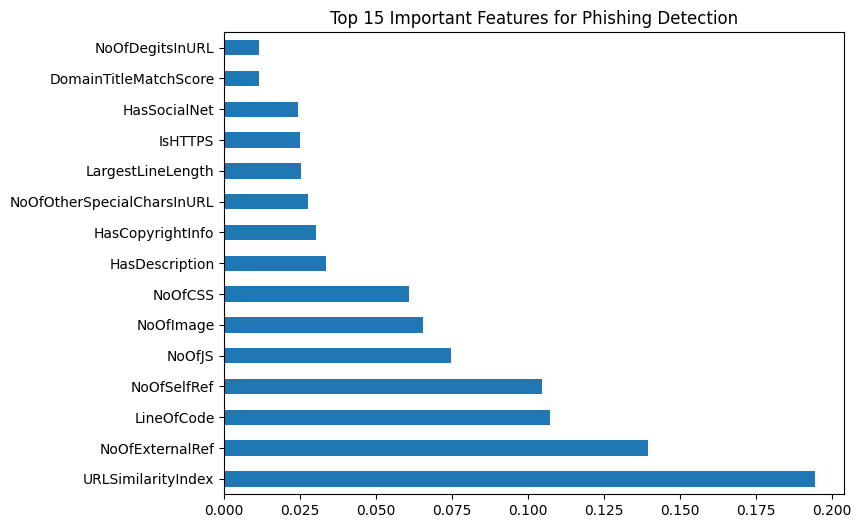

In [ ]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(model_rf.feature_importances_, index=X_proc.columns)
feature_importances.nlargest(15).plot(kind='barh', figsize=(8,6))
plt.title("Top 15 Important Features for Phishing Detection")
plt.show()


In [ ]:
!pip install gradio -q


In [ ]:
import gradio as gr
import pandas as pd
import tldextract

# Reuse your trained model: model_rf from Step 9

def extract_features(url):
    """Convert a URL into numeric features."""
    url = str(url)
    features = {}
    features['url_length'] = len(url)
    features['num_dots'] = url.count('.')
    features['num_hyphens'] = url.count('-')
    features['has_https'] = int(url.lower().startswith('https'))
    features['has_ip'] = int(bool(pd.Series([url]).str.contains(r'(?:\d{1,3}\.){3}\d{1,3}')[0]))
    features['suspicious_kw'] = int(bool(pd.Series([url]).str.contains(
        r'login|verify|secure|update|account|signin|pay|confirm', case=False
    )[0]))
    ext = tldextract.extract(url)
    features['subdomain_depth'] = 0 if ext.subdomain == '' else len(ext.subdomain.split('.'))
    brands = ['paypal','google','amazon','microsoft','apple','facebook','bankofamerica']
    features['brand_present'] = int(any(b in ext.domain.lower() for b in brands))
    features['brand_exact'] = int(ext.domain.lower() in brands)

    return pd.DataFrame([features])

def predict_url(url):
    """Predict if a URL is legit or phishing."""
    if not url.strip():
        return "❌ Please enter a URL."
    feats = extract_features(url)
    pred = model_rf.predict(feats)[0]
    return "✅ Legit" if pred == 0 else "🚨 Phishing"

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("# 🛡️ Phishing URL Detector")
    url_input = gr.Textbox(label="Enter URL to check", placeholder="https://example.com")
    output = gr.Label()
    check_btn = gr.Button("Check URL")
    check_btn.click(fn=predict_url, inputs=url_input, outputs=output)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d2260b6517a4c493bd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import pandas as pd
import tldextract

# Keep a global history list
history_data = []

# Feature extraction (same as before)
def extract_features(url):
    url = str(url)
    features = {}
    features['url_length'] = len(url)
    features['num_dots'] = url.count('.')
    features['num_hyphens'] = url.count('-')
    features['has_https'] = int(url.lower().startswith('https'))
    features['has_ip'] = int(bool(pd.Series([url]).str.contains(r'(?:\d{1,3}\.){3}\d{1,3}')[0]))
    features['suspicious_kw'] = int(bool(pd.Series([url]).str.contains(
        r'login|verify|secure|update|account|signin|pay|confirm', case=False
    )[0]))
    ext = tldextract.extract(url)
    features['subdomain_depth'] = 0 if ext.subdomain == '' else len(ext.subdomain.split('.'))
    brands = ['paypal','google','amazon','microsoft','apple','facebook','bankofamerica']
    features['brand_present'] = int(any(b in ext.domain.lower() for b in brands))
    features['brand_exact'] = int(ext.domain.lower() in brands)
    return pd.DataFrame([features])

# Prediction function with history
def predict_url_with_history(url):
    if not url.strip():
        return "❌ Please enter a URL.", pd.DataFrame(history_data, columns=["URL", "Result"])

    feats = extract_features(url)
    pred = model_rf.predict(feats)[0]
    result = "✅ Legit" if pred == 0 else "🚨 Phishing"

    # Add to history
    history_data.append([url, result])
    history_df = pd.DataFrame(history_data, columns=["URL", "Result"])

    return result, history_df

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("# 🛡️ Phishing URL Detector with History")
    url_input = gr.Textbox(label="Enter URL to check", placeholder="https://example.com")
    check_btn = gr.Button("Check URL")
    output_label = gr.Label()
    history_table = gr.Dataframe(headers=["URL", "Result"], datatype=["str", "str"], interactive=False)

    check_btn.click(fn=predict_url_with_history, inputs=url_input, outputs=[output_label, history_table])

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://04bf7cc8a0cf843e50.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
